# Preparing data

We will use **IMDb movie review dataset** for binary sentiment analysis (http://ai.stanford.edu/~amaas/data/sentiment/).

Since the data is represented in particular files for each review, we need to apply some helper functions to collect data properly.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize, WordPunctTokenizer


RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

In [3]:
PATH = 'drive/My Drive/aclImdb'

def tokenize_text(text):
    return WordPunctTokenizer().tokenize(text)

def collect_data(filename):
    data = []
    with open(os.path.join(PATH, filename), 'r') as file:
        for paragraph in file.read().splitlines():
            data.append(tokenize_text(paragraph))
    return data

In [10]:
X_train_pos = collect_data('X_train_pos')
X_train_neg = collect_data('X_train_neg')

X_test_pos = collect_data('X_test_pos')
X_test_neg = collect_data('X_test_neg')

In [11]:
X_train = np.array(X_train_pos + X_train_neg)
X_test = np.array(X_test_pos + X_test_neg)

In [12]:
Y_train = np.concatenate((np.ones(len(X_train_pos)), np.zeros(len(X_train_neg))))
Y_test = np.concatenate((np.ones(len(X_test_pos)), np.zeros(len(X_test_neg))))

In [13]:
from sklearn.utils import shuffle

In [14]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=RANDOM_STATE)
X_test, Y_test = shuffle(X_test, Y_test, random_state=RANDOM_STATE)

In [15]:
print(Y_train[:10])

[0. 1. 0. 0. 1. 1. 0. 0. 0. 1.]


# Build word embeddings to represent texts


##Word2Vec embeddings

First we want to load pre-trained **word2vec** to represent words with vectors, so words that appear in similar contexts will have vectors with greater scalar product. Then we can try different ways to represent texts: as mean of vectors of incoming words and etc.

In [16]:
import gensim.downloader as api
from gensim.models import Word2Vec

In [17]:
corpus = api.load('text8')
word2vec = Word2Vec(corpus, size=100, window=5, min_count=5).wv

[==================================================] 100.0% 31.6/31.6MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


So, now we can find words with most similar contexts to some word, for instance *'kubrick'*.

In [18]:
word2vec.most_similar('kubrick')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('welles', 0.8147057294845581),
 ('gilliam', 0.7923753261566162),
 ('lugosi', 0.7823293209075928),
 ('spielberg', 0.7822622060775757),
 ('lynch', 0.7798724174499512),
 ('gibson', 0.7789876461029053),
 ('mitchell', 0.7761475443840027),
 ('burton', 0.7652144432067871),
 ('chuck', 0.7608257532119751),
 ('ellison', 0.7587131857872009)]

Now we can start representing texts to learn an algorithm on the training data that predicts texts' labels! Let's try different ways to get text's embedding.

In [19]:
def mean_text_embedding(text, embeddings, word_vectors):  
    return np.mean(np.array([word_vectors[word] for word in text if word in embeddings.vocab.keys()]), axis=0)

In [20]:
class EmbeddingMaker():
    def __init__(self, embeddings, text_function):
        self.embeddings = embeddings
        self.text_function = text_function
        self._form_word_structures(self.embeddings)
    
    def _form_word_structures(self, embeddings):
        self.words = sorted(self.embeddings.vocab.keys(),
                            key=lambda word: self.embeddings.vocab[word].count,
                            reverse=True)
        self.word_vectors = {word : self.embeddings.get_vector(word) for word in self.words}

    def __call__(self, text):
        return self.text_function(text, self.embeddings, self.word_vectors)

In [21]:
def get_corpus_embeddings(embedding_maker, corpus):
    return np.array(list(map(embedding_maker.__call__, corpus)))

In [22]:
word2vec_mean = EmbeddingMaker(word2vec, mean_text_embedding)

In [23]:
word2vec_mean(X_train[0])

array([ 0.57362086,  0.29828757, -0.4933205 , -0.83055913, -0.07225075,
        0.00909969,  0.10959946, -0.45122203, -0.17620215, -0.4445463 ,
       -0.63245517, -0.11729913,  0.47881216, -0.6529626 , -0.06516301,
        0.19171765,  0.02726305, -0.38329756, -0.11225718, -0.28526422,
       -0.04536623, -0.20621371, -0.59878665,  0.2020082 ,  0.03584569,
       -0.52425534,  0.7428178 , -0.03543884,  0.40518472, -0.18640548,
        0.09132709,  0.3468964 ,  0.80867946, -0.2134231 , -0.14305004,
        0.06318384,  0.3722802 ,  0.2049067 ,  0.16272496,  0.15234794,
       -0.10167218,  0.03378916, -0.300579  , -0.18439527,  0.17163058,
       -0.09305833, -0.2271106 , -0.01006022,  0.4475775 ,  0.26468927,
        0.5274127 , -0.23585136,  0.08727198, -0.204906  ,  0.10495421,
        0.48674166,  0.02261339,  0.41680846,  0.3735793 , -0.02945423,
        0.27866784, -0.6928578 , -1.3176901 ,  0.6689034 , -0.0574524 ,
        0.29842833, -0.16592444, -0.57602984, -1.0368615 , -0.04

In [24]:
X_train_mean_word2vec = get_corpus_embeddings(word2vec_mean, X_train)

In [25]:
print(X_train_mean_word2vec.shape)

(25000, 100)


In [26]:
X_test_mean_word2vec = get_corpus_embeddings(word2vec_mean, X_test)

###Linear models performance

In [27]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [28]:
class EstimatorChecker():
    def __init__(self, estimator, method_name, X_train, Y_train, X_test, Y_test, verbose=0):
        self.estimator = estimator
        self.method_name = method_name
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.verbose = verbose

    def fit_to_best_params(self, param_grid):
        self.searcher = RandomizedSearchCV(self.estimator, param_grid, 
                                           n_iter=5, cv=3, 
                                           random_state=RANDOM_STATE, verbose=self.verbose)
        self.searcher.fit(self.X_train, self.Y_train)

        self.estimator.set_params(**self.searcher.best_params_)
        print('{} best params: {}'.format(self.method_name, self.searcher.best_params_))
        print('Best cross_val score: {}'.format(self.searcher.best_score_))

    def fit(self):
        self.estimator = self.estimator.fit(self.X_train, self.Y_train)

    def predict(self):
        self.Y_pred = self.estimator.predict(self.X_test)
        return self.Y_pred

    def print_scores(self):
        self.scores = [accuracy_score(self.Y_test, self.Y_pred), 
                       precision_score(self.Y_test, self.Y_pred), 
                       recall_score(self.Y_test, self.Y_pred)]

        print('Scores for {}:'.format(self.method_name))
        print('Accuracy: {}'.format(self.scores[0]))
        print('Precision: {}'.format(self.scores[1]))
        print('Recall: {}'.format(self.scores[2]))


    def plot_roc_curve(self):
        fpr, tpr, _ = roc_curve(self.Y_test, 
                                self.estimator.predict_proba(self.X_test)[:, 1], 
                                pos_label=1)
        plt.figure(figsize=(15, 8))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.grid(c='g')
        plt.title('ROC-curve for {}'.format(self.method_name))
        self.auc = auc(fpr, tpr)
        print('Area under ROC-curve: {:1.4f}'.format(self.auc))
        plt.plot(fpr, tpr)
        plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), 'r')
        plt.show()

    def iterate_and_report(self):
        self.fit()
        self.predict()
        self.print_scores()
        self.plot_roc_curve()

In [122]:
log_regr = EstimatorChecker(estimator=LogisticRegression(max_iter=300, random_state=RANDOM_STATE),
                                method_name='Logistic Regression',
                                X_train=X_train_mean_word2vec,
                                Y_train=Y_train,
                                X_test=X_test_mean_word2vec,
                                Y_test=Y_test
                            )

In [123]:
log_regr_param_grid = {'fit_intercept' : [True, False], 
                       'C' : np.logspace(-4, 3, num=8)}
log_regr.fit_to_best_params(log_regr_param_grid)

Logistic Regression best params: {'fit_intercept': False, 'C': 100.0}
Best cross_val score: 0.7487998392025914


Scores for Logistic Regression:
Accuracy: 0.74812
Precision: 0.7520520113774888
Recall: 0.74032
Area under ROC-curve: 0.8206


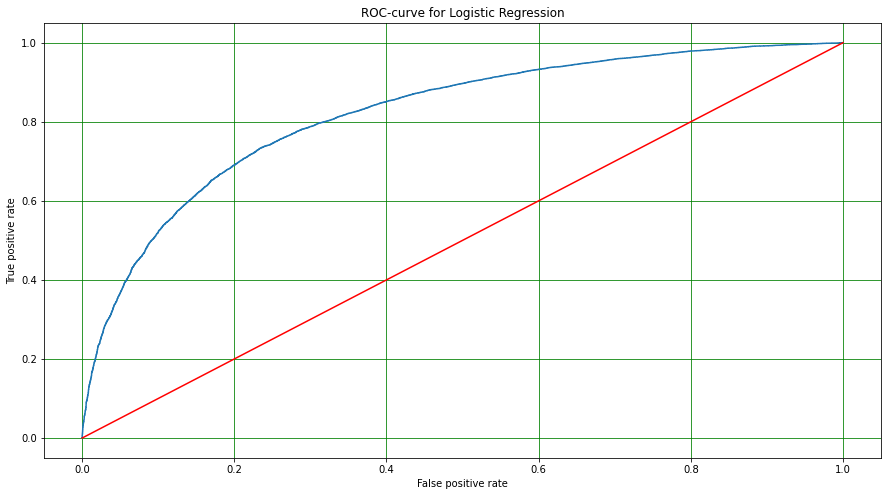

In [124]:
log_regr.iterate_and_report()

In [32]:
word_weights = np.array([np.dot(log_regr.estimator.coef_, word2vec_mean.word_vectors[word]) for word in word2vec_mean.words])

In [33]:
top_weights = np.argsort(word_weights, axis=0)[-10:].ravel()
print('Words with top lr weights:', [word2vec_mean.words[i] for i in top_weights])

Words with top lr weights: ['affairs', 'wars', 'world', 'career', 'tour', 'relationship', 'united', 'association', 'relations', 'links']


In [34]:
stock_weights = np.argsort(word_weights, axis=0)[:10].ravel()
print('Words with stock lr weights:', [word2vec_mean.words[i] for i in stock_weights])

Words with stock lr weights: ['either', 'soviet', 'whether', 'al', 'prevent', 'killed', 'immune', 'cause', 'than', 'any']


In [39]:
test_texts_indexes = np.argsort(np.dot(log_regr.estimator.coef_, X_test_mean_word2vec.T)).ravel()

In [51]:
print('Most positive text:', ' '.join(X_test[test_texts_indexes[-1]]))

Most positive text: more suspenseful , more subtle , much , much more disturbing ....


In [50]:
print('Most negative text:', ' '.join(X_test[test_texts_indexes[0]]))

Most negative text: this movie sucks . did anyone notice that the entire movie was shot in like 2 rooms . there are never any outside shots and if there are its obviously film taken from somewhere else . this movie blows hard , painful to sit through too . stay far away .


In [67]:
Y_pred = log_regr.estimator.predict_proba(X_test_mean_word2vec)[:, 1]

worst_text_idx = np.argsort((Y_test - Y_pred) ** 2)[::-1][:5]

print('Worst classified texts:', '\n\n'.join(' '.join(text) for text in X_test[worst_text_idx]))
print(f'Y_pred is {Y_pred[worst_text_idx]} and Y_true is {Y_test[worst_text_idx]}')

Worst classified texts: more suspenseful , more subtle , much , much more disturbing ....

..... whoops - looks like it ' s gonna cost you a whopping £ 198 . 00 to buy a copy ( either dvd or video format ) from itv direct . ouch . sorry about this , but imdb won ' t let me submit this comment unless it has at least 10 lines , so ........... blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblah !!

i had to watch this movie for professional reasons and can only say it ' s a complete waste of time . when running , baldwin looks like an ape , characters are dull , same story has been told 1000 times bet

Whoops, worst classified text seems to be sarcastic... We'll probably deal with it later.

In [68]:
rf = EstimatorChecker(estimator=RandomForestClassifier(random_state=1),
                            method_name='Random Forest',
                            X_train=X_train_mean_word2vec,
                            Y_train=Y_train,
                            X_test=X_test_mean_word2vec,
                            Y_test=Y_test,
                            verbose=2
                      )

In [69]:
rf_param_grid = {'n_estimators' : np.linspace(100, 200, 101).astype(int), 
                 'max_depth' : np.linspace(5, 20, 6).astype(int)}
rf.fit_to_best_params(rf_param_grid)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=137, max_depth=5 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=137, max_depth=5, total=   9.5s
[CV] n_estimators=137, max_depth=5 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] .................... n_estimators=137, max_depth=5, total=   9.5s
[CV] n_estimators=137, max_depth=5 ...................................
[CV] .................... n_estimators=137, max_depth=5, total=   9.4s
[CV] n_estimators=133, max_depth=11 ..................................
[CV] ................... n_estimators=133, max_depth=11, total=  16.5s
[CV] n_estimators=133, max_depth=11 ..................................
[CV] ................... n_estimators=133, max_depth=11, total=  16.5s
[CV] n_estimators=133, max_depth=11 ..................................
[CV] ................... n_estimators=133, max_depth=11, total=  16.4s
[CV] n_estimators=172, max_depth=5 ...................................
[CV] .................... n_estimators=172, max_depth=5, total=  11.8s
[CV] n_estimators=172, max_depth=5 ...................................
[CV] .................... n_estimators=172, max_depth=5, total=  11.7s
[CV] n_estimators=172, max_depth=5 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.2min finished


Random Forest best params: {'n_estimators': 133, 'max_depth': 11}
Best cross_val score: 0.7056798998621812


Scores for Random Forest:
Accuracy: 0.6968
Precision: 0.7107969151670951
Recall: 0.6636
Area under ROC-curve: 0.7714


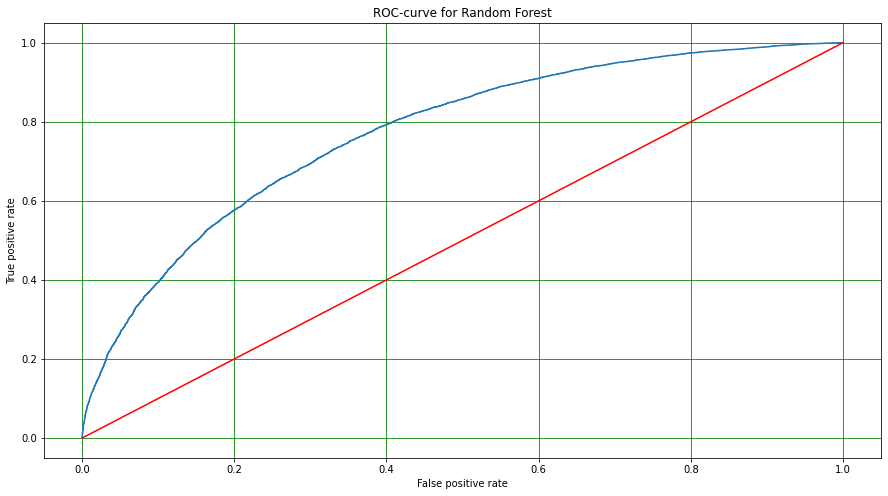

In [70]:
rf.iterate_and_report()

In [125]:
sgd = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                          method_name='SGD',
                          X_train=X_train_mean_word2vec,
                          Y_train=Y_train,
                          X_test=X_test_mean_word2vec,
                          Y_test=Y_test
                       )

In [126]:
sgd_param_grid = {'loss' : ['modified_huber', 'log'],
                  'penalty' : ['l1', 'l2', 'elasticnet']}
sgd.fit_to_best_params(sgd_param_grid)

SGD best params: {'penalty': 'l1', 'loss': 'log'}
Best cross_val score: 0.7395998455728966


Scores for SGD:
Accuracy: 0.74152
Precision: 0.7878527841342486
Recall: 0.66104
Area under ROC-curve: 0.8213


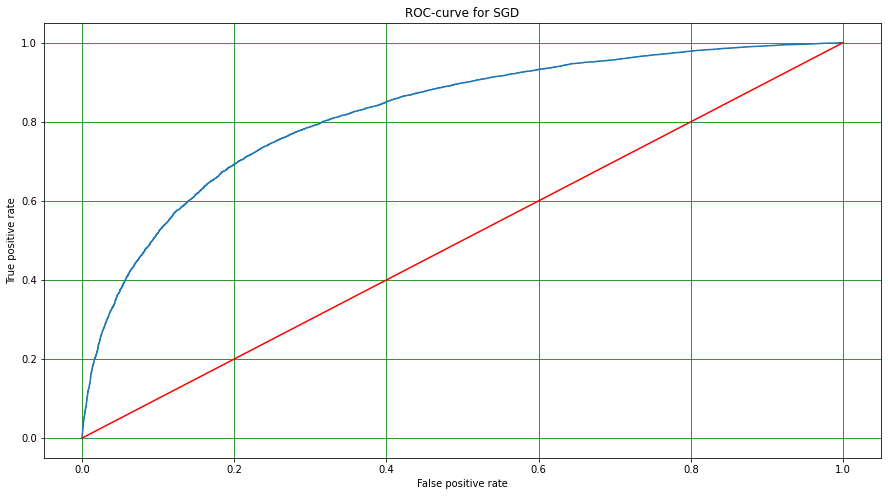

In [127]:
sgd.iterate_and_report()

Because of the way we form word and text embeddings, we can't just scale the data after that, because the idea of word2vec would be lost. So SVM has problems with convergency, but we can check it's quality after a fixed amount of iterations.

In [74]:
svm = EstimatorChecker(SVC(max_iter=1000, random_state=RANDOM_STATE, probability=True),
                          method_name='SVM',
                          X_train=X_train_mean_word2vec,
                          Y_train=Y_train,
                          X_test=X_test_mean_word2vec,
                          Y_test=Y_test,
                          verbose=2
                       )

In [ ]:
svm_param_grid = {'C' : np.logspace(-4, 3, 8),
                  'kernel' : ['linear', 'poly', 'rbf']}
svm.fit_to_best_params(svm_param_grid)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Scores for SVM:
Accuracy: 0.56652
Precision: 0.5382915035689615
Recall: 0.93512
Area under ROC-curve: 0.7105


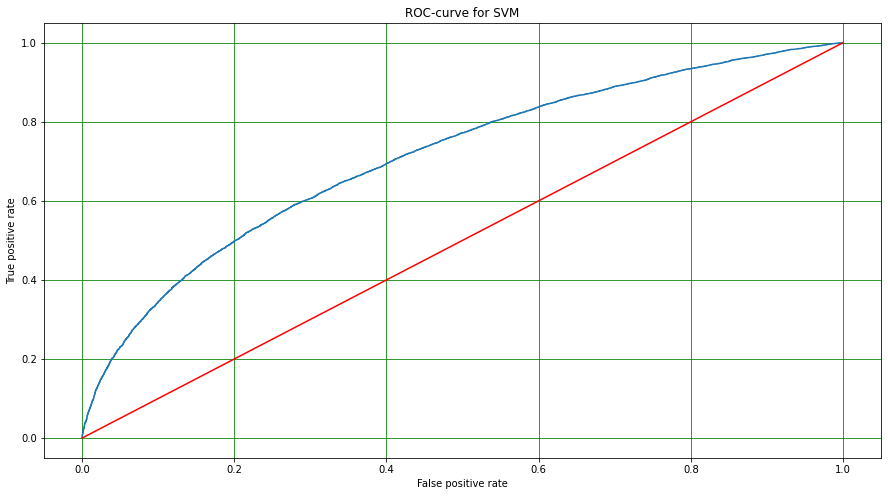

In [76]:
svm.iterate_and_report()

Yes, SVM has problems with convergence, but now we can try to train it more with best obtained params and see what we can get.

In [84]:
best_params_svm = EstimatorChecker(SVC(max_iter=5000, kernel='linear', C=0.001, random_state=RANDOM_STATE, probability=True),
                          method_name='Best params SVM',
                          X_train=X_train_mean_word2vec,
                          Y_train=Y_train,
                          X_test=X_test_mean_word2vec,
                          Y_test=Y_test
                       )

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Scores for Best params SVM:
Accuracy: 0.53464
Precision: 0.5181095775826015
Recall: 0.99104
Area under ROC-curve: 0.8009


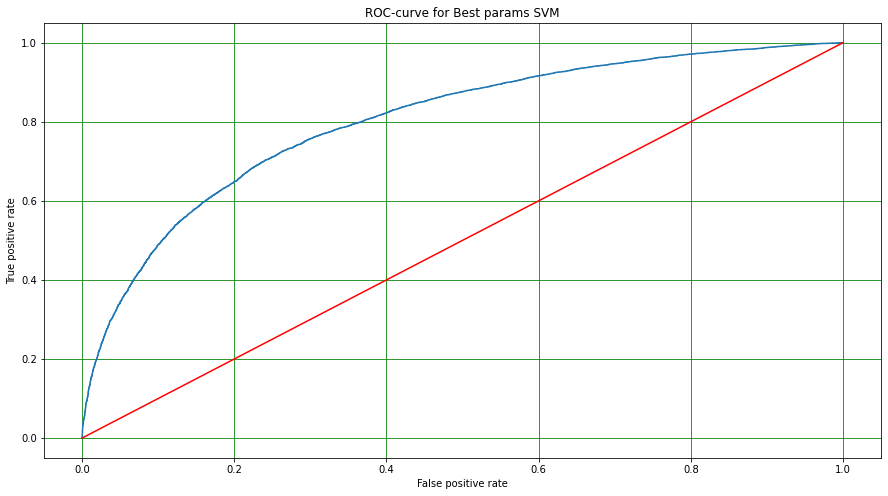

In [85]:
best_params_svm.iterate_and_report()

In [120]:
from IPython.display import display


def print_results_table(models):
    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'Roc-auc']

    results_table = pd.DataFrame(list(map(lambda x: [x.method_name] + x.scores + [x.auc], models)), columns=columns)
    display(results_table)

In [128]:
print_results_table([log_regr, rf, svm, best_params_svm, sgd])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.74812,0.752052,0.74032,0.820607
1,Random Forest,0.69680,0.710797,0.66360,0.771417
2,SVM,0.56652,0.538292,0.93512,0.710466
3,Best params SVM,0.53464,0.518110,0.99104,0.800904
4,SGD,0.74152,0.787853,0.66104,0.821255


Interesting results! LR and SGD have the greatest roc-auc score. SGD also has the best precision, but as a trade-off the worst recall. As we also can see, well-trained SVM gets huge recall and even not bad roc-auc score, but a very bad accuracy and precision. 

It looks like in later linear models analysis we should use Logistic Regression and SGD, because they train much faster, have best roc-auc scores and not bad other scores.

Let's now try another way to form text embeddings, for instance, as a sum of all words embeddings instead of taking mean. On the one hand, it causes the dependance between embeddings and text lengths, but on the other hand necessary words may not 'drown' in hundreds of unnecessary tokens.

In [111]:
def sum_text_embedding(text, embeddings, word_vectors):  
    return np.sum(np.array([word_vectors[word] for word in text if word in embeddings.vocab.keys()]), axis=0)

In [112]:
word2vec_sum = EmbeddingMaker(word2vec, sum_text_embedding)

In [113]:
X_train_sum_word2vec = get_corpus_embeddings(word2vec_sum, X_train)

X_test_sum_word2vec = get_corpus_embeddings(word2vec_sum, X_test)

In [140]:
log_regr_sum = EstimatorChecker(estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                method_name='Logistic Regression',
                                X_train=X_train_sum_word2vec,
                                Y_train=Y_train,
                                X_test=X_test_sum_word2vec,
                                Y_test=Y_test
                            )

Logistic Regression best params: {'fit_intercept': False, 'C': 100.0}
Best cross_val score: 0.7481998871987517
Scores for Logistic Regression:
Accuracy: 0.74804
Precision: 0.751602694149152
Recall: 0.74096
Area under ROC-curve: 0.8152


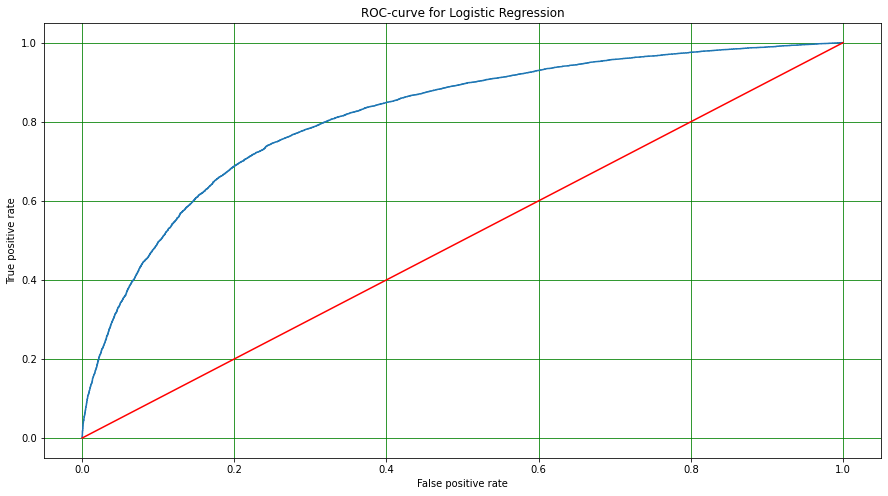

In [141]:
log_regr_sum.fit_to_best_params(log_regr_param_grid)
log_regr_sum.iterate_and_report()

In [131]:
sgd_sum = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                          method_name='SGD',
                          X_train=X_train_sum_word2vec,
                          Y_train=Y_train,
                          X_test=X_test_sum_word2vec,
                          Y_test=Y_test
                       )

SGD best params: {'penalty': 'l1', 'loss': 'modified_huber'}
Best cross_val score: 0.732679947946658
Scores for SGD:
Accuracy: 0.55452
Precision: 0.5292753125134241
Recall: 0.98568
Area under ROC-curve: 0.5545


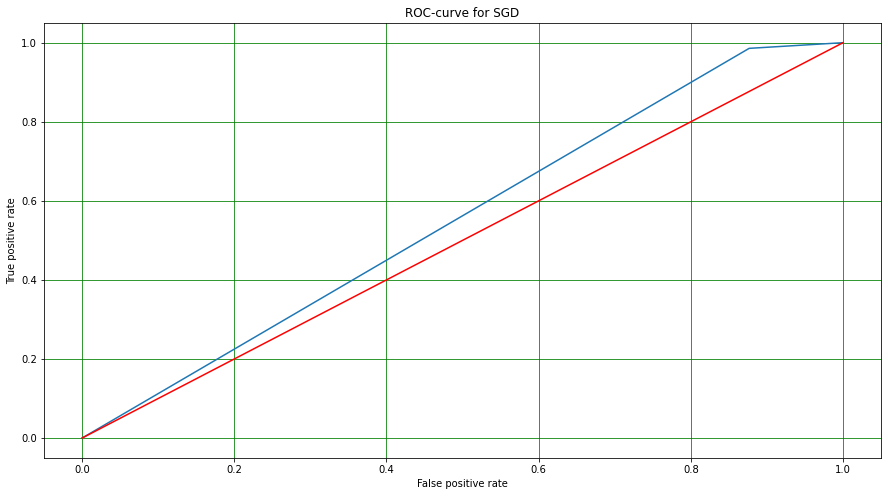

In [132]:
sgd_sum.fit_to_best_params(sgd_param_grid)
sgd_sum.iterate_and_report()

In [142]:
print_results_table([log_regr_sum, sgd_sum])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.74804,0.751603,0.74096,0.815155
1,SGD,0.55452,0.529275,0.98568,0.554519


It looks like Logistic Regression's performance hasn't changed, but SGD works must worse with sumation of embeddings. So, this approach seems to be not better than taking mean of words' embeddings.

Let's now try taking median on every component of words' embeddings.

In [143]:
def median_text_embedding(text, embeddings, word_vectors):
    return np.median(np.array([word_vectors[word] for word in text if word in embeddings.vocab.keys()]), axis=0)

In [144]:
word2vec_median = EmbeddingMaker(word2vec, median_text_embedding)

In [145]:
X_train_median_word2vec = get_corpus_embeddings(word2vec_median, X_train)

X_test_median_word2vec = get_corpus_embeddings(word2vec_median, X_test)

In [149]:
log_regr_median = EstimatorChecker(estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                method_name='Logistic Regression',
                                X_train=X_train_median_word2vec,
                                Y_train=Y_train,
                                X_test=X_test_median_word2vec,
                                Y_test=Y_test
                            )

Logistic Regression best params: {'fit_intercept': False, 'C': 100.0}
Best cross_val score: 0.7347200967472345
Scores for Logistic Regression:
Accuracy: 0.73336
Precision: 0.7351660754595292
Recall: 0.72952
Area under ROC-curve: 0.8058


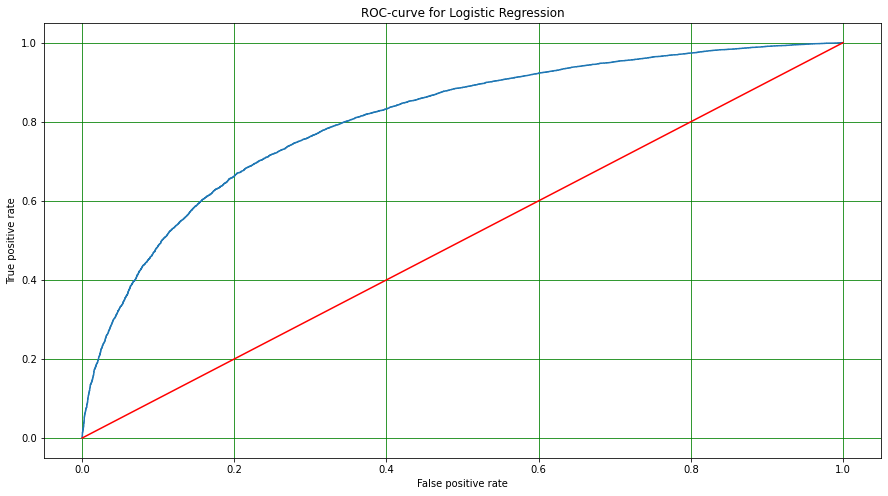

In [150]:
log_regr_median.fit_to_best_params(log_regr_param_grid)
log_regr_median.iterate_and_report()

In [151]:
sgd_median = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                          method_name='SGD',
                          X_train=X_train_median_word2vec,
                          Y_train=Y_train,
                          X_test=X_test_median_word2vec,
                          Y_test=Y_test
                       )

SGD best params: {'penalty': 'l2', 'loss': 'log'}
Best cross_val score: 0.724119538335649
Scores for SGD:
Accuracy: 0.72592
Precision: 0.695567867036011
Recall: 0.80352
Area under ROC-curve: 0.8059


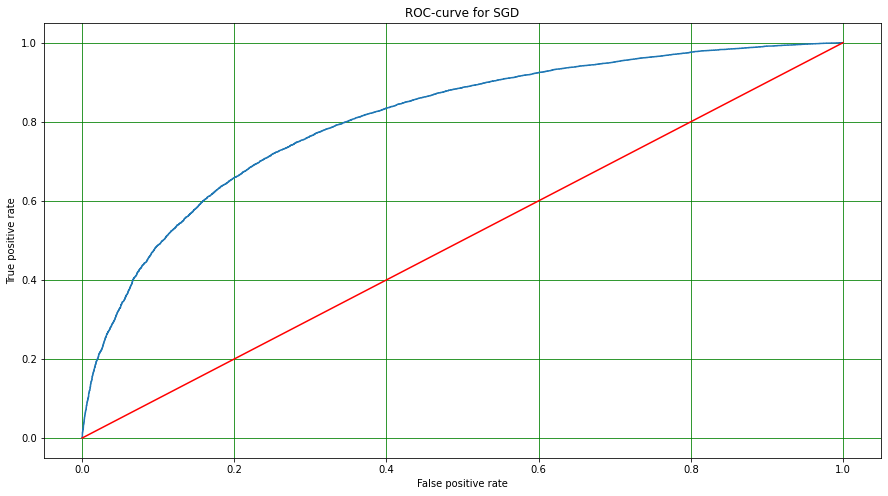

In [152]:
sgd_median.fit_to_best_params(sgd_param_grid)
sgd_median.iterate_and_report()

In [153]:
print_results_table([log_regr_median, sgd_median])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.73336,0.735166,0.72952,0.805820
1,SGD,0.72592,0.695568,0.80352,0.805879


Logistic Regression is still pretty stable :) Although roc-auc score has decreased.

SGD now also works not bad, but in a precision-recall trade-off it now has better recall, compared to it's performance with mean embeddings.

So let's try the last approch: we'll take maximum of each component and see what happens.

In [154]:
def max_text_embedding(text, embeddings, word_vectors):
    return np.max(np.array([word_vectors[word] for word in text if word in embeddings.vocab.keys()]), axis=0)

In [155]:
word2vec_max = EmbeddingMaker(word2vec, max_text_embedding)

In [156]:
X_train_max_word2vec = get_corpus_embeddings(word2vec_max, X_train)

X_test_max_word2vec = get_corpus_embeddings(word2vec_max, X_test)

In [159]:
print(X_train_max_word2vec.shape)

(25000, 100)


In [157]:
log_regr_max = EstimatorChecker(estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                method_name='Logistic Regression',
                                X_train=X_train_max_word2vec,
                                Y_train=Y_train,
                                X_test=X_test_max_word2vec,
                                Y_test=Y_test
                            )

Logistic Regression best params: {'fit_intercept': True, 'C': 0.1}
Best cross_val score: 0.6463195940844593
Scores for Logistic Regression:
Accuracy: 0.64604
Precision: 0.6526210183095059
Recall: 0.62448
Area under ROC-curve: 0.6990


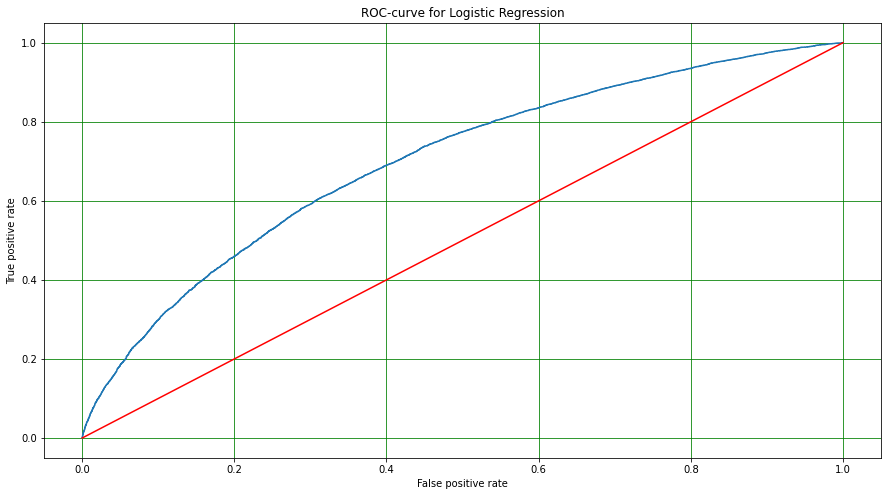

In [158]:
log_regr_max.fit_to_best_params(log_regr_param_grid)
log_regr_max.iterate_and_report()

In [160]:
sgd_max = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                          method_name='SGD',
                          X_train=X_train_max_word2vec,
                          Y_train=Y_train,
                          X_test=X_test_max_word2vec,
                          Y_test=Y_test
                       )

SGD best params: {'penalty': 'l2', 'loss': 'modified_huber'}
Best cross_val score: 0.5989612370671933
Scores for SGD:
Accuracy: 0.51356
Precision: 0.8265895953757225
Recall: 0.03432
Area under ROC-curve: 0.5389


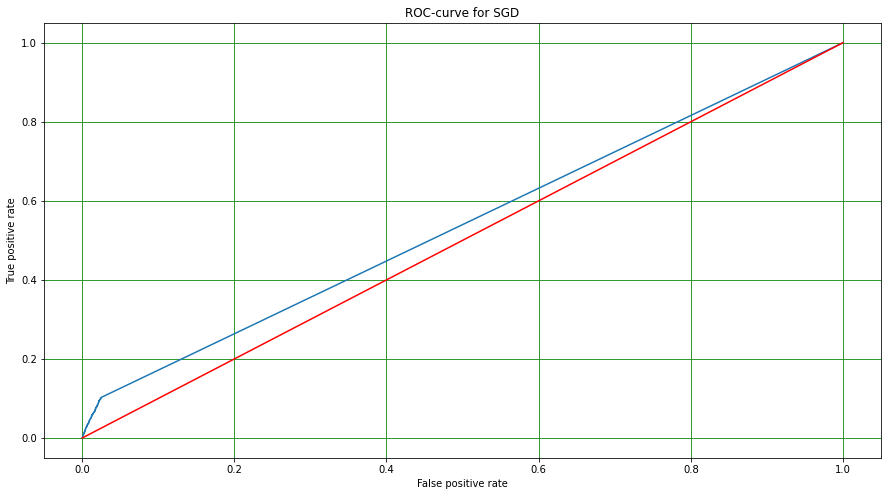

In [161]:
sgd_max.fit_to_best_params(sgd_param_grid)
sgd_max.iterate_and_report()

In [162]:
print_results_table([log_regr_max, sgd_max])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.64604,0.652621,0.62448,0.699049
1,SGD,0.51356,0.826590,0.03432,0.538863


So, we can see that the last approach was the worst one. SGD's recall seems like it considered a lot of texts as negative.

---

As a conclusion we have that Logistic Regression got the most sustained results and kept one the highest roc-auc scores at all kinds of texts' embeddings. But the best approach was to take the mean embeddings.

##Glove embeddings

Word2vec isn't the only way to get words embeddings. Another popular type of embeddings is Glove. Now we can also try them to get words embedding with the best models from the last paragraph: Logistic Regression and SGD, and the best way of getting text's embeddings: taking mean of embeddings of it's words.

In [163]:
glove = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [164]:
glove.most_similar('kubrick')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('spielberg', 0.7951244711875916),
 ('welles', 0.7051688432693481),
 ('soderbergh', 0.7047620415687561),
 ('selznick', 0.6845448613166809),
 ('altman', 0.681014358997345),
 ('bergman', 0.6685311794281006),
 ('capote', 0.6658517122268677),
 ('screenplay', 0.661378800868988),
 ('hitchcock', 0.6600087881088257),
 ('zemeckis', 0.6493422389030457)]

In [165]:
glove_mean = EmbeddingMaker(glove, mean_text_embedding)

In [166]:
X_train_mean_glove = get_corpus_embeddings(glove_mean, X_train)

X_test_mean_glove = get_corpus_embeddings(glove_mean, X_test)

###Linear models performance

In [167]:
log_regr_glove = EstimatorChecker(estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                            method_name='Logistic Regression',
                            X_train=X_train_mean_glove,
                            Y_train=Y_train,
                            X_test=X_test_mean_glove,
                            Y_test=Y_test
                          )

Logistic Regression best params: {'fit_intercept': False, 'C': 100.0}
Best cross_val score: 0.7592000584271031
Scores for Logistic Regression:
Accuracy: 0.75
Precision: 0.7559377559377559
Recall: 0.7384
Area under ROC-curve: 0.8266


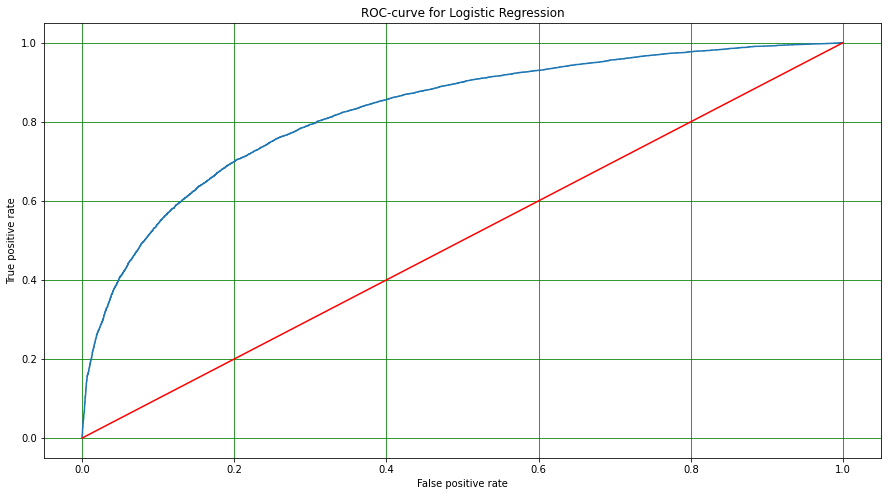

In [168]:
log_regr_glove.fit_to_best_params(log_regr_param_grid)
log_regr_glove.iterate_and_report()

In [171]:
sgd_glove = EstimatorChecker(SGDClassifier(random_state=RANDOM_STATE),
                          method_name='SGD',
                          X_train=X_train_mean_glove,
                          Y_train=Y_train,
                          X_test=X_test_mean_glove,
                          Y_test=Y_test
                       )

SGD best params: {'penalty': 'l1', 'loss': 'log'}
Best cross_val score: 0.7565197928291502
Scores for SGD:
Accuracy: 0.74976
Precision: 0.7986416682609527
Recall: 0.66792
Area under ROC-curve: 0.8275


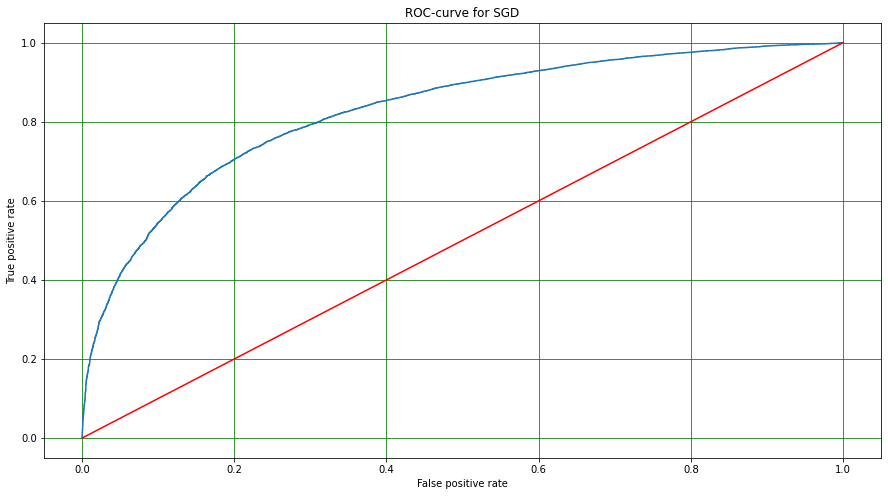

In [172]:
sgd_glove.fit_to_best_params(sgd_param_grid)
sgd_glove.iterate_and_report()

As we can see, performance of models is a bit better than with word2vec embedding. So, we can also try to train Rndom Forest, that performed not bad, but now give him a bigger number of estimators and greater max_depth.

In [191]:
rf_glove = EstimatorChecker(estimator=RandomForestClassifier(random_state=RANDOM_STATE),
                            method_name='Random Forest',
                            X_train=X_train_mean_glove,
                            Y_train=Y_train,
                            X_test=X_test_mean_glove,
                            Y_test=Y_test,
                            verbose=2
                          )

In [192]:
rf_glove.fit_to_best_params({'n_estimators' : np.linspace(200, 400, 101).astype(int), 
                             'max_depth' : np.linspace(17, 32, 6).astype(int)})

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=274, max_depth=17 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... n_estimators=274, max_depth=17, total=  28.8s
[CV] n_estimators=274, max_depth=17 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.8s remaining:    0.0s


[CV] ................... n_estimators=274, max_depth=17, total=  28.9s
[CV] n_estimators=274, max_depth=17 ..................................
[CV] ................... n_estimators=274, max_depth=17, total=  28.9s
[CV] n_estimators=266, max_depth=23 ..................................
[CV] ................... n_estimators=266, max_depth=23, total=  29.2s
[CV] n_estimators=266, max_depth=23 ..................................
[CV] ................... n_estimators=266, max_depth=23, total=  29.1s
[CV] n_estimators=266, max_depth=23 ..................................
[CV] ................... n_estimators=266, max_depth=23, total=  29.1s
[CV] n_estimators=344, max_depth=17 ..................................
[CV] ................... n_estimators=344, max_depth=17, total=  36.1s
[CV] n_estimators=344, max_depth=17 ..................................
[CV] ................... n_estimators=344, max_depth=17, total=  36.4s
[CV] n_estimators=344, max_depth=17 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.7min finished


Random Forest best params: {'n_estimators': 266, 'max_depth': 23}
Best cross_val score: 0.7534800936073919


Scores for Random Forest:
Accuracy: 0.74676
Precision: 0.744200775868894
Recall: 0.752
Area under ROC-curve: 0.8225


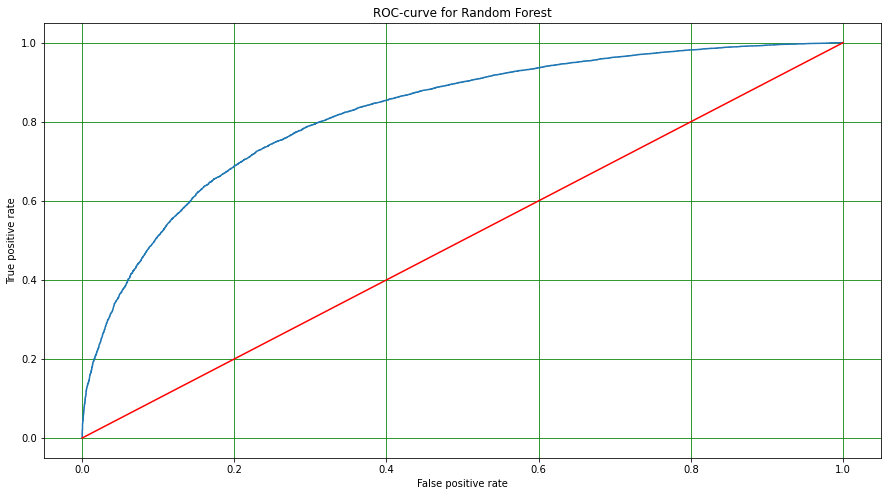

In [193]:
rf_glove.iterate_and_report()

In [194]:
print_results_table([log_regr_glove, sgd_glove, rf_glove])

,Model,Accuracy,Precision,Recall,Roc-auc
0,Logistic Regression,0.75000,0.755938,0.73840,0.826633
1,SGD,0.74976,0.798642,0.66792,0.827500
2,Random Forest,0.74676,0.744201,0.75200,0.822500


So, as a conclusion, all models have a bit better performance with glove embeddings. The performance of bigger random forest is also better, but still a little worse than Logistic Regression's and SGD's.

---

Probably the best model for this part of research is Logistic Regression with C=100, without bias vector, with text embeddings taken as mean of words' glove embeddings.